In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install kaggle

In [ ]:
!pip install kaggle
!rm -rf ~/.kaggle
!pwd
import json
token = {"username":"username","key":"apikey"} #create in kaggle setting
with open("kaggle.json", "w") as file:
  json.dump(token, file)

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

/content


In [ ]:
!kaggle datasets download -d niyarrbarman/landslide-divided

Dataset URL: https://www.kaggle.com/datasets/niyarrbarman/landslide-divided
License(s): CC0-1.0
 96% 53.0M/54.9M [00:00<00:00, 135MB/s]
100% 54.9M/54.9M [00:00<00:00, 127MB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/landslide-divided.zip')
zip_ref.extractall('/content/landslide-divided')
zip_ref.close()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input,Conv2D,BatchNormalization,Activation,MaxPool2D,Conv2DTranspose,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,CSVLogger

In [ ]:
#seeding
import tensorflow as tf
import glob as glob
import cv2
os.environ['PYTHONHASHSEED']=str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
batch_size=8
lr=1e-4
epochs=100
height=768
width=512

In [ ]:
dataset_path=os.path.join('/content/landslide-divided/dataset')

In [ ]:
files_dir='/content/files'
model_file='/content/files/unet-test.keras'
log_file='/content/files/unet-log.csv'

In [ ]:
def create_files(path):
  os.makedirs(path)
create_files(files_dir)

In [ ]:
def conv_block(inputs,num_filters):
  x=Conv2D(num_filters,3,padding='same')(inputs)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)

  x=Conv2D(num_filters,3,padding="same")(x)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)

  return x

In [ ]:
def Encoder_block(inputs,num_filters):
  x=conv_block(inputs,num_filters)# for the skip connection
  p=MaxPool2D((2,2))(x)# output for the Encoder block

  return x,p

In [ ]:
def decoder_block(inputs,skip,num_filters):
  x=Conv2DTranspose(num_filters,2,strides=2,padding='same')(inputs)
  x=Concatenate()([x,skip])
  x=conv_block(x,num_filters)

  return x

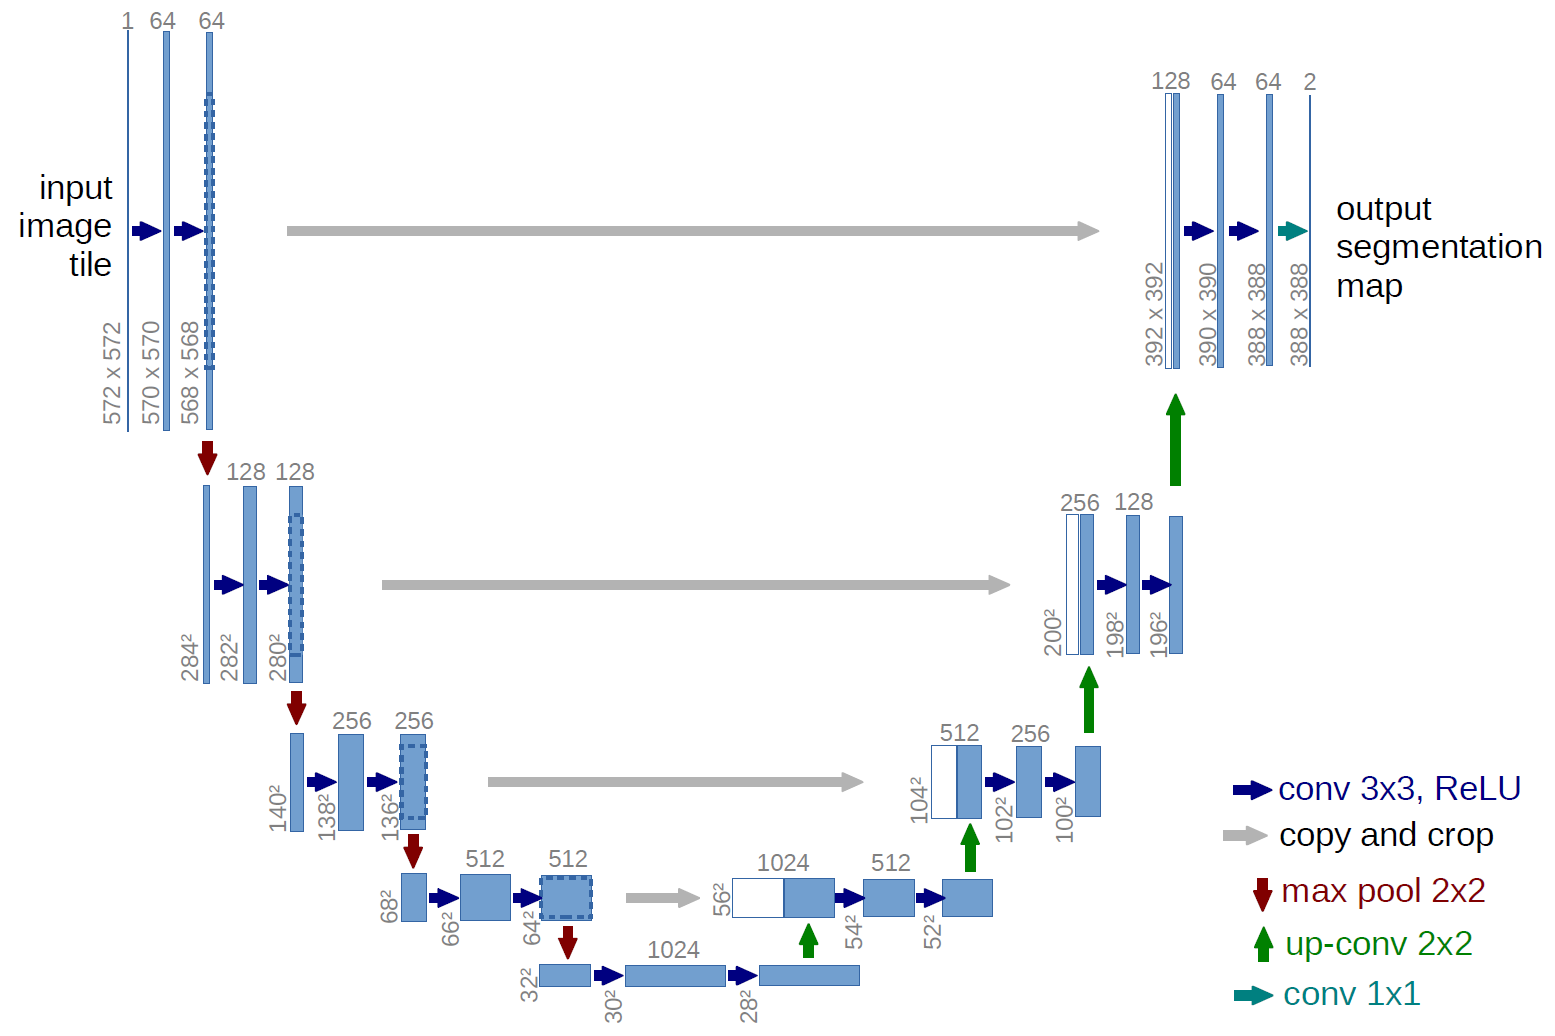

In [ ]:
def build_unet(input_shape):

  inputs=Input(shape=input_shape)
  """Encoder"""
  s1,p1=Encoder_block(inputs,64)
  s2,p2=Encoder_block(p1,128)
  s3,p3=Encoder_block(p2,256)
  s4,p4=Encoder_block(p3,512)

  """BETWEEN PART"""

  b1=conv_block(p4,1024)

  """Decoder Part"""
  #inputs,skip,num_filters
  d1=decoder_block(b1,s4,512)
  d2=decoder_block(d1,s3,256)
  d3=decoder_block(d2,s2,128)
  d4=decoder_block(d3,s1,64)

  """ LAST LAYER BEFORE FINAL SEGEMNTED IMAGE"""
  outputs=Conv2D(1,1,padding='same',activation='sigmoid')(d4)

  model=Model(inputs=inputs,outputs=outputs,name='u-net')

  return model

PIPELINE DAL DO

In [ ]:
import glob
import os
path="landslide-divided/dataset"
train_x=glob.glob(os.path.join(path,"train","images","*"))
train_y=glob.glob(os.path.join(path,"train","masks","*"))

valid_x=glob.glob(os.path.join(path,"valid","images","*"))
valid_y=glob.glob(os.path.join(path,"valid","masks","*"))

test_x=glob.glob(os.path.join(path,"test","images","*"))
test_y=glob.glob(os.path.join(path,"test","masks","*"))



In [ ]:
# Reading images
def read_image(x):
  x=tf.io.read_file(x)
  x=tf.io.decode_png(x,channels=3)
  x = tf.cast(x, tf.float32) / 255.0
  return x

In [ ]:
# Reading masks
def read_masks(x):
  x=tf.io.read_file(x)
  x=tf.io.decode_png(x,channels=1)
  x = tf.cast(x, tf.float32) / 255.0
  return x

In [ ]:
model=build_unet((128,128,3))

In [ ]:
model.summary()

Model: "u-net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
opt=tf.keras.optimizers.Adam(lr)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
callbacks=[
    ModelCheckpoint(model_file,verbose=1,save_best_only=True),#Saves the weights only if validation loss improves # verbose =1 displays messages when the callback takes an action.
    ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=False)
]

In [ ]:
train_x = tf.data.Dataset.list_files("/content/landslide-divided/dataset/train/images/*.png", shuffle=False)
train_y = tf.data.Dataset.list_files("/content/landslide-divided/dataset/train/masks/*.png", shuffle=False)

train_dataset = tf.data.Dataset.zip((train_x, train_y))

In [ ]:
def load_and_preprocess(image_file, mask_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image, channels=3)  # Decode image as RGB
    image = tf.image.resize(image, (128, 128))  # Resize image to 128x128
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_file)
    mask = tf.image.decode_png(mask, channels=1)  # Decode mask as grayscale (1 channel)
    mask = tf.image.resize(mask, (128, 128))  # Resize mask to 128x128
    mask = tf.cast(mask, tf.float16) / 255.0
    return image, mask

train_dataset = train_dataset.map(load_and_preprocess)

train_dataset = train_dataset.shuffle(1000).batch(32)#.repeat() function is used to repeat the dataset indefinitely

In [ ]:
validation_x = tf.data.Dataset.list_files("/content/landslide-divided/dataset/validation/images/*.png", shuffle=False)
validation_y = tf.data.Dataset.list_files("/content/landslide-divided/dataset/validation/masks/*.png", shuffle=False)

validaion_dataset = tf.data.Dataset.zip((validation_x, validation_y))

validation_dataset=validaion_dataset.map(load_and_preprocess)
validation_dataset = validation_dataset.shuffle(1000).batch(32)

In [ ]:
history=model.fit(train_dataset,validation_data=validation_dataset,epochs=21,callbacks=callbacks)

Epoch 1/21
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8415 - loss: 0.4899   
Epoch 1: val_loss improved from inf to 0.57299, saving model to /content/files/unet-test.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8430 - loss: 0.4875 - val_accuracy: 0.9597 - val_loss: 0.5730 - learning_rate: 1.0000e-04
Epoch 2/21
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9604 - loss: 0.2070
Epoch 2: val_loss improved from 0.57299 to 0.35619, saving model to /content/files/unet-test.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 42s 550ms/step - accuracy: 0.9605 - loss: 0.2067 - val_accuracy: 0.9597 - val_loss: 0.3562 - learning_rate: 1.0000e-04
Epoch 3/21
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9644 - loss: 0.1590
Epoch 3: val_loss improved from 0.35619 to 0.24756, saving model to /content/files/unet-test.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 46s 673ms/step - accuracy: 0.9643 - loss: 0.1590 - val_accuracy: 0.9597 - val_loss: 0.2476 - learning_rate: 1.0000e-04
Epoch 4/21
44

In [ ]:
model.save('weights.h5')

In [ ]:
model.save('weights.keras')

In [ ]:
import h5py

file_path = '/content/weights.h5'

try:
    with h5py.File(file_path, 'r') as f:
        print("The .h5 file is valid!")
except Exception as e:
    print(f"Error reading .h5 file: {e}")


The .h5 file is valid!


In [ ]:
model.save_weights('/content/weights_only.weights.h5')  # Save in HDF5 format


In [ ]:
import pandas as pd
df=pd.read_csv('/content/files/unet-log.csv')

In [ ]:
df.head()


,epoch,accuracy,learning_rate,loss,val_accuracy,val_loss
0,0,0.928031,0.0001,0.324773,0.959714,0.559861
1,1,0.962540,0.0001,0.171857,0.959714,0.336900
2,2,0.963237,0.0001,0.139216,0.959714,0.238480
3,3,0.965635,0.0001,0.123514,0.959714,0.194007
4,4,0.966035,0.0001,0.118778,0.959714,0.171401


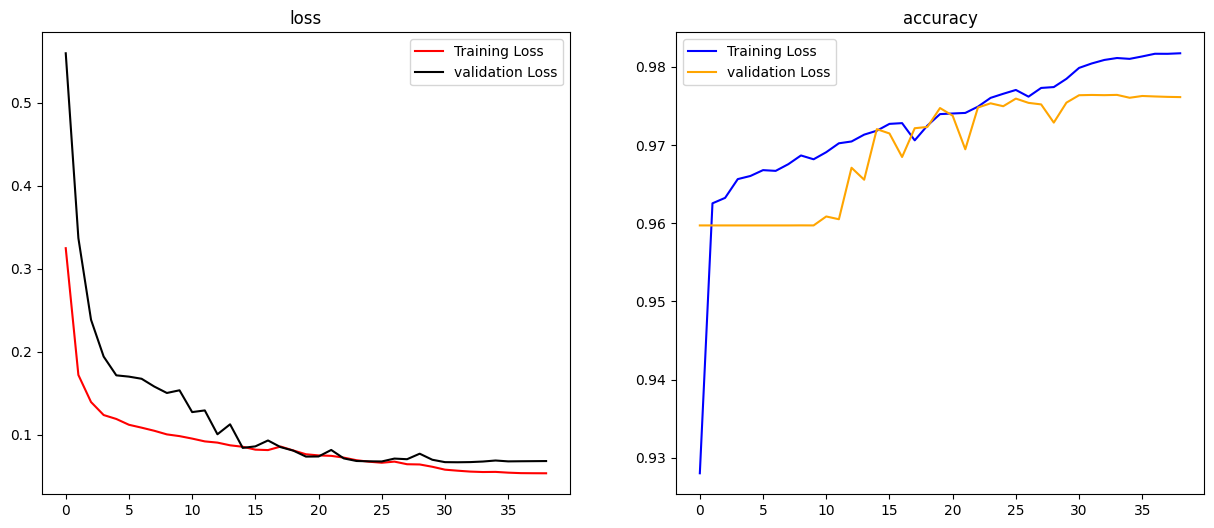

In [ ]:

import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,2,figsize=(15,6))

ax[0].title.set_text('loss')
ax[0].plot((df['loss']),color='r',label='Training Loss')
ax[0].plot((df['val_loss']),color='black',label='validation Loss')
ax[0].legend()

ax[1].title.set_text('accuracy')
ax[1].plot((df['accuracy']),color='blue',label='Training Loss')
ax[1].plot((df['val_accuracy']),color='orange',label='validation Loss')

plt.legend()
plt.show()

In [ ]:
test_data= "/content/landslide-divided/dataset/test/images/image_100.png"
image = tf.io.read_file(test_data)
image = tf.image.decode_png(image, channels=3)  # Decode image as RGB
image = tf.image.resize(image, (128, 128))

In [ ]:
a=np.expand_dims(image,axis=0)
a.shape

(1, 128, 128, 3)

In [ ]:
y_hat=model.predict(a)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
y_hat=model.predict(a)

In [ ]:
y_hat=np.squeeze(y_hat,axis=0)

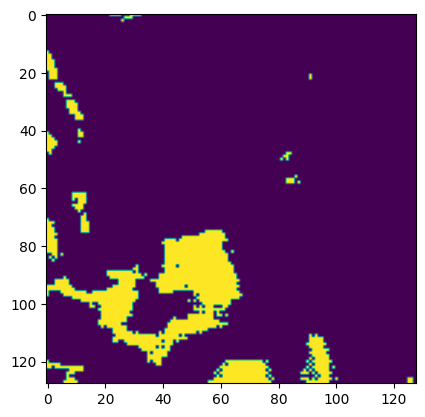

In [ ]:
plt.imshow(y_hat)
